In [9]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows',999)
pd.set_option('display.max_columns', 999)
 


In [2]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Toronto').text
soup = BeautifulSoup(source, 'lxml')
table = soup.find('table', {'class':'wikitable sortable'})

In [3]:
district_number = []
neighborhood = []
a = []
b = []
c = []

for row in table.findAll('tr'):
    cells = row.findAll('td')
    if len(cells)==2:
        a.append(cells[0].find(text=True))
        b.append(cells[1].findAll(text=True))
        
for i in b:
    for j in i:
        if j == ', ':
            i.remove(j)
df = pd.DataFrame()
df['District number'] = a
df['Neighborhood'] = b


In [4]:
for i in df['Neighborhood']:
    if '\n' in i:
        i = i[:-1]
        neighborhood.append(i)
    else:
        neighborhood.append(i)

for i in df['District number']:
    if '\n' in i:
        i = i[:-1]
        district_number.append(i)
    else:
        district_number.append(i)
        
df['Neighborhood'] = neighborhood
df['District number'] = district_number

In [5]:
def Insert_row(row_number, df, row_value): 
    start_upper = 0
    end_upper = row_number 
    start_lower = row_number 
    end_lower = df.shape[0] 
    upper_half = [*range(start_upper, end_upper, 1)] 
    lower_half = [*range(start_lower, end_lower, 1)] 
    lower_half = [x.__add__(1) for x in lower_half] 
    index_ = upper_half + lower_half 
    df.index = index_ 
    df.loc[row_number] = row_value 
    df = df.sort_index() 
    return df 

row_number = 19
row_value = ['E07', '[Agincourt, East L\'amoreaux, Milliken]']
if row_number > df.index.max()+1: 
    print("Invalid row_number") 
else: 
    df = Insert_row(row_number, df, row_value) 

    
row_number = 10
row_value = ['C12', '[York Mills (West), Don Mills(North)]']
if row_number > df.index.max()+1: 
    print("Invalid row_number") 
else: 
    df = Insert_row(row_number, df, row_value) 


csv file containing latitude and longitude of the districts

In [6]:
location = pd.read_csv('district_coordinates.csv') 
condo = pd.read_csv('condo.csv')
house = pd.read_csv('house.csv')


In [7]:
df['Latitude'] = location['Latitude']
df['Longitude'] = location['Longitude']
df['Condo percentage'] = condo['condo increase percentage']
df['House percentage'] = house['house increase percentage']
df['Postal code'] = condo['postal code']

Foursquare to identify venues in these districts

In [10]:
CLIENT_ID = 'FOVA0ZMSD3ONHLRE5AWRE0QEMTHWKSUXDLEGRO53LS0TPYBP'
CLIENT_SECRET = 'B1W23OBLYPZWKA4TSNZJH45ZCNHAI2XXVAVB2PQYXTY4S3SW'
VERSION = '20190914'

address = 'Toronto, ON'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
LIMIT = 100

In [11]:
def getNearbyVenues(names, latitudes, longitudes, percent, radius=1500):
    
    venues_list=[]
    for name, lat, lng, per in zip(names, latitudes, longitudes, percent):
        

        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            per,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District number', 
                  'District Latitude', 
                  'District Longitude', 
                  'Percentage',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Change between house and condo percentage

In [12]:
toronto_venues = getNearbyVenues(names=df['District number'],
                                latitudes=df['Latitude'],
                                longitudes=df['Longitude'],
                                percent = df['House percentage']
                                #percent = df['Condo percentage']
                                )

In [13]:
toronto_venues

,District number,District Latitude,District Longitude,Percentage,Venue,Venue Latitude,Venue Longitude,Venue Category
0,C01,43.653206,-79.400049,51,Seven Lives - Tacos y Mariscos,43.654418,-79.400545,Mexican Restaurant
1,C01,43.653206,-79.400049,51,Kid Icarus,43.653933,-79.401719,Arts & Crafts Store
2,C01,43.653206,-79.400049,51,Jimmy's Coffee,43.654493,-79.401311,Café
3,C01,43.653206,-79.400049,51,The Moonbean Cafe,43.654147,-79.400182,Café
4,C01,43.653206,-79.400049,51,Blackbird Baking Co,43.654764,-79.400566,Bakery
...,...,...,...,...,...,...,...,...
2028,W10,43.732144,-79.589335,56,Sunnydale Outdoor Rink,43.724608,-79.578065,Skating Rink
2029,W10,43.732144,-79.589335,56,Dollar Tree,43.729349,-79.574295,Discount Store
2030,W10,43.732144,-79.589335,56,Salvation Army Thrift Store,43.728928,-79.573884,Thrift / Vintage Store
2031,W10,43.732144,-79.589335,56,Value Village,43.737068,-79.605281,Thrift / Vintage Store


In [14]:
toronto_venues.groupby('District number').count()

,District Latitude,District Longitude,Percentage,Venue,Venue Latitude,Venue Longitude,Venue Category
District number,,,,,,,
C01,100,100,100,100,100,100,100
C02,100,100,100,100,100,100,100
C03,95,95,95,95,95,95,95
C04,51,51,51,51,51,51,51
C06,32,32,32,32,32,32,32
C07,17,17,17,17,17,17,17
C08,100,100,100,100,100,100,100
C09,100,100,100,100,100,100,100
C10,89,89,89,89,89,89,89


In [15]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot['District number'] = toronto_venues['District number'] 
toronto_onehot['Percentage'] = toronto_venues['Percentage']
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

cols = list(toronto_onehot)
cols.insert(0, cols.pop(cols.index('District number')))
toronto_onehot = toronto_onehot.loc[:, cols]

toronto_onehot

,District number,Percentage,Afghan Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Quad,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Hardware Store,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotpot Restaurant,Housing Development,Hungarian Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Museum,Music School,Music Store,Nail Salon,Neighborhood,New American Restaurant,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pide Place,Pie Shop,Pizza Place,Playground,Pool,Portuguese Restaurant,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Rock Climbing Spot,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Skating Rink,Ski Chalet,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stables,Steakhouse,Storage Facility,Street Art,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,C01,51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [16]:
toronto_grouped = toronto_onehot.groupby('District number').mean().reset_index()
num_top_venues = 30

for hood in toronto_grouped['District number']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['District number'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[2:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


----C01----
                            venue  freq
0                            Café  0.10
1                     Coffee Shop  0.06
2                             Bar  0.06
3   Vegetarian / Vegan Restaurant  0.04
4            Caribbean Restaurant  0.03
5              Mexican Restaurant  0.03
6                     Art Gallery  0.03
7                      Taco Place  0.02
8                    Dessert Shop  0.02
9                Tapas Restaurant  0.02
10                         Bakery  0.02
11                 Sandwich Place  0.02
12                    Pizza Place  0.02
13          Vietnamese Restaurant  0.02
14              French Restaurant  0.02
15                     Restaurant  0.02
16            Arts & Crafts Store  0.02
17                    Yoga Studio  0.02
18        Comfort Food Restaurant  0.01
19                            Gym  0.01
20                            Spa  0.01
21                      Speakeasy  0.01
22                  Grocery Store  0.01
23            Sporting Goods

29            Food & Drink Shop  0.01


----W02----
                    venue  freq
0             Coffee Shop  0.10
1                     Bar  0.08
2                    Café  0.07
3      Italian Restaurant  0.04
4            Burger Joint  0.03
5             Pizza Place  0.03
6          Breakfast Spot  0.03
7                  Bakery  0.02
8           Grocery Store  0.02
9          Clothing Store  0.02
10        Thai Restaurant  0.02
11              Gastropub  0.02
12     Mexican Restaurant  0.02
13                   Park  0.02
14       Sushi Restaurant  0.02
15             Nail Salon  0.02
16    Arts & Crafts Store  0.02
17  Vietnamese Restaurant  0.02
18            Flea Market  0.02
19              Pet Store  0.02
20             Food Truck  0.01
21                    Gym  0.01
22            Supermarket  0.01
23                    Pub  0.01
24      Electronics Store  0.01
25             Sports Bar  0.01
26              Speakeasy  0.01
27        Organic Grocery  0.01
28             Soup 

In [17]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['District number']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['District number'] = toronto_grouped['District number']
for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted['Percentage'] = toronto_grouped['Percentage']
cols = neighborhoods_venues_sorted.columns.tolist()
cols = cols[-1:] + cols[:-1]
neighborhoods_venues_sorted = neighborhoods_venues_sorted[cols]

In [18]:
neighborhoods_venues_sorted.sort_values('Percentage')

,Percentage,District number,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,18,C06,Park,Coffee Shop,Convenience Store,Sushi Restaurant,Bank,Middle Eastern Restaurant,Baseball Field,French Restaurant,Restaurant,Sandwich Place
9,20,C11,Coffee Shop,Indian Restaurant,Sandwich Place,Burger Joint,Restaurant,Electronics Store,Sporting Goods Shop,Furniture / Home Store,Bank,Park
10,21,C12,Cosmetics Shop,Ice Cream Shop,Burger Joint,Bus Line,Supermarket,Café,Shopping Mall,Sandwich Place,Park,General Entertainment
11,24,C13,Coffee Shop,American Restaurant,Sandwich Place,Pharmacy,Gym / Fitness Center,Restaurant,Japanese Restaurant,Ice Cream Shop,Café,Shopping Mall
18,26,E05,Coffee Shop,Chinese Restaurant,Fast Food Restaurant,Pizza Place,Pool,Tennis Court,Pharmacy,Bakery,Flower Shop,Food & Drink Shop
20,28,E07,Coffee Shop,Bubble Tea Shop,Vietnamese Restaurant,Chinese Restaurant,Sandwich Place,Ice Cream Shop,Bakery,Dessert Shop,Discount Store,Supermarket
12,31,C14,Korean Restaurant,Coffee Shop,Bubble Tea Shop,Japanese Restaurant,Bank,Ramen Restaurant,Dessert Shop,Pizza Place,Fast Food Restaurant,Sandwich Place
21,33,E08,Fast Food Restaurant,Coffee Shop,Park,Restaurant,Sandwich Place,Trail,Pharmacy,Pub,Seafood Restaurant,Shopping Mall
23,34,E10,Park,Gym / Fitness Center,Burger Joint,Italian Restaurant,Grocery Store,Gym,Breakfast Spot,Dance Studio,Doner Restaurant,Field
1,36,C02,Italian Restaurant,Café,Coffee Shop,Restaurant,Grocery Store,French Restaurant,Park,Gym,Vegetarian / Vegan Restaurant,Pizza Place


In [25]:
condo_res_count = pd.read_csv('house_res.csv') 
x = condo_res_count['percentage']
y = condo_res_count['number of restaurants']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=1)

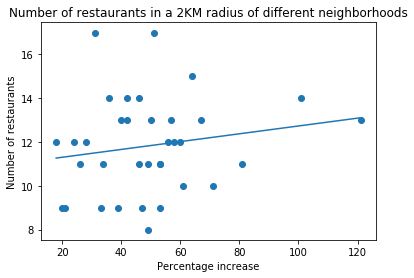

In [39]:
plt.scatter(condo_x, condo_y)
plt.title('Number of restaurants in a 2KM radius of different neighborhoods')
plt.xlabel('Percentage increase')
plt.ylabel('Number of restaurants')
plt.plot(np.unique(condo_x), np.poly1d(np.polyfit(condo_x, condo_y, 1))(np.unique(condo_x)))
plt.show()